In [1]:
%load_ext autoreload
%autoreload 2

# 1. Crop images

In [6]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)

In [7]:
def move_to_device(segmentor_model, device="cuda:0"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

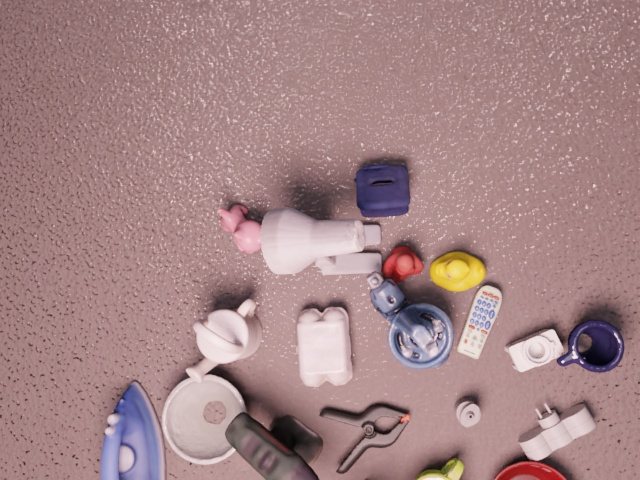

In [8]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "lmo"
rgb_path = f"datasets/bop23_challenge/datasets/{dataset}/train_pbr/000031/rgb/000002.jpg"
rgb = Image.open(rgb_path).convert("RGB")
detections = custom_sam_model.generate_masks(np.array(rgb))
rgb

In [4]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

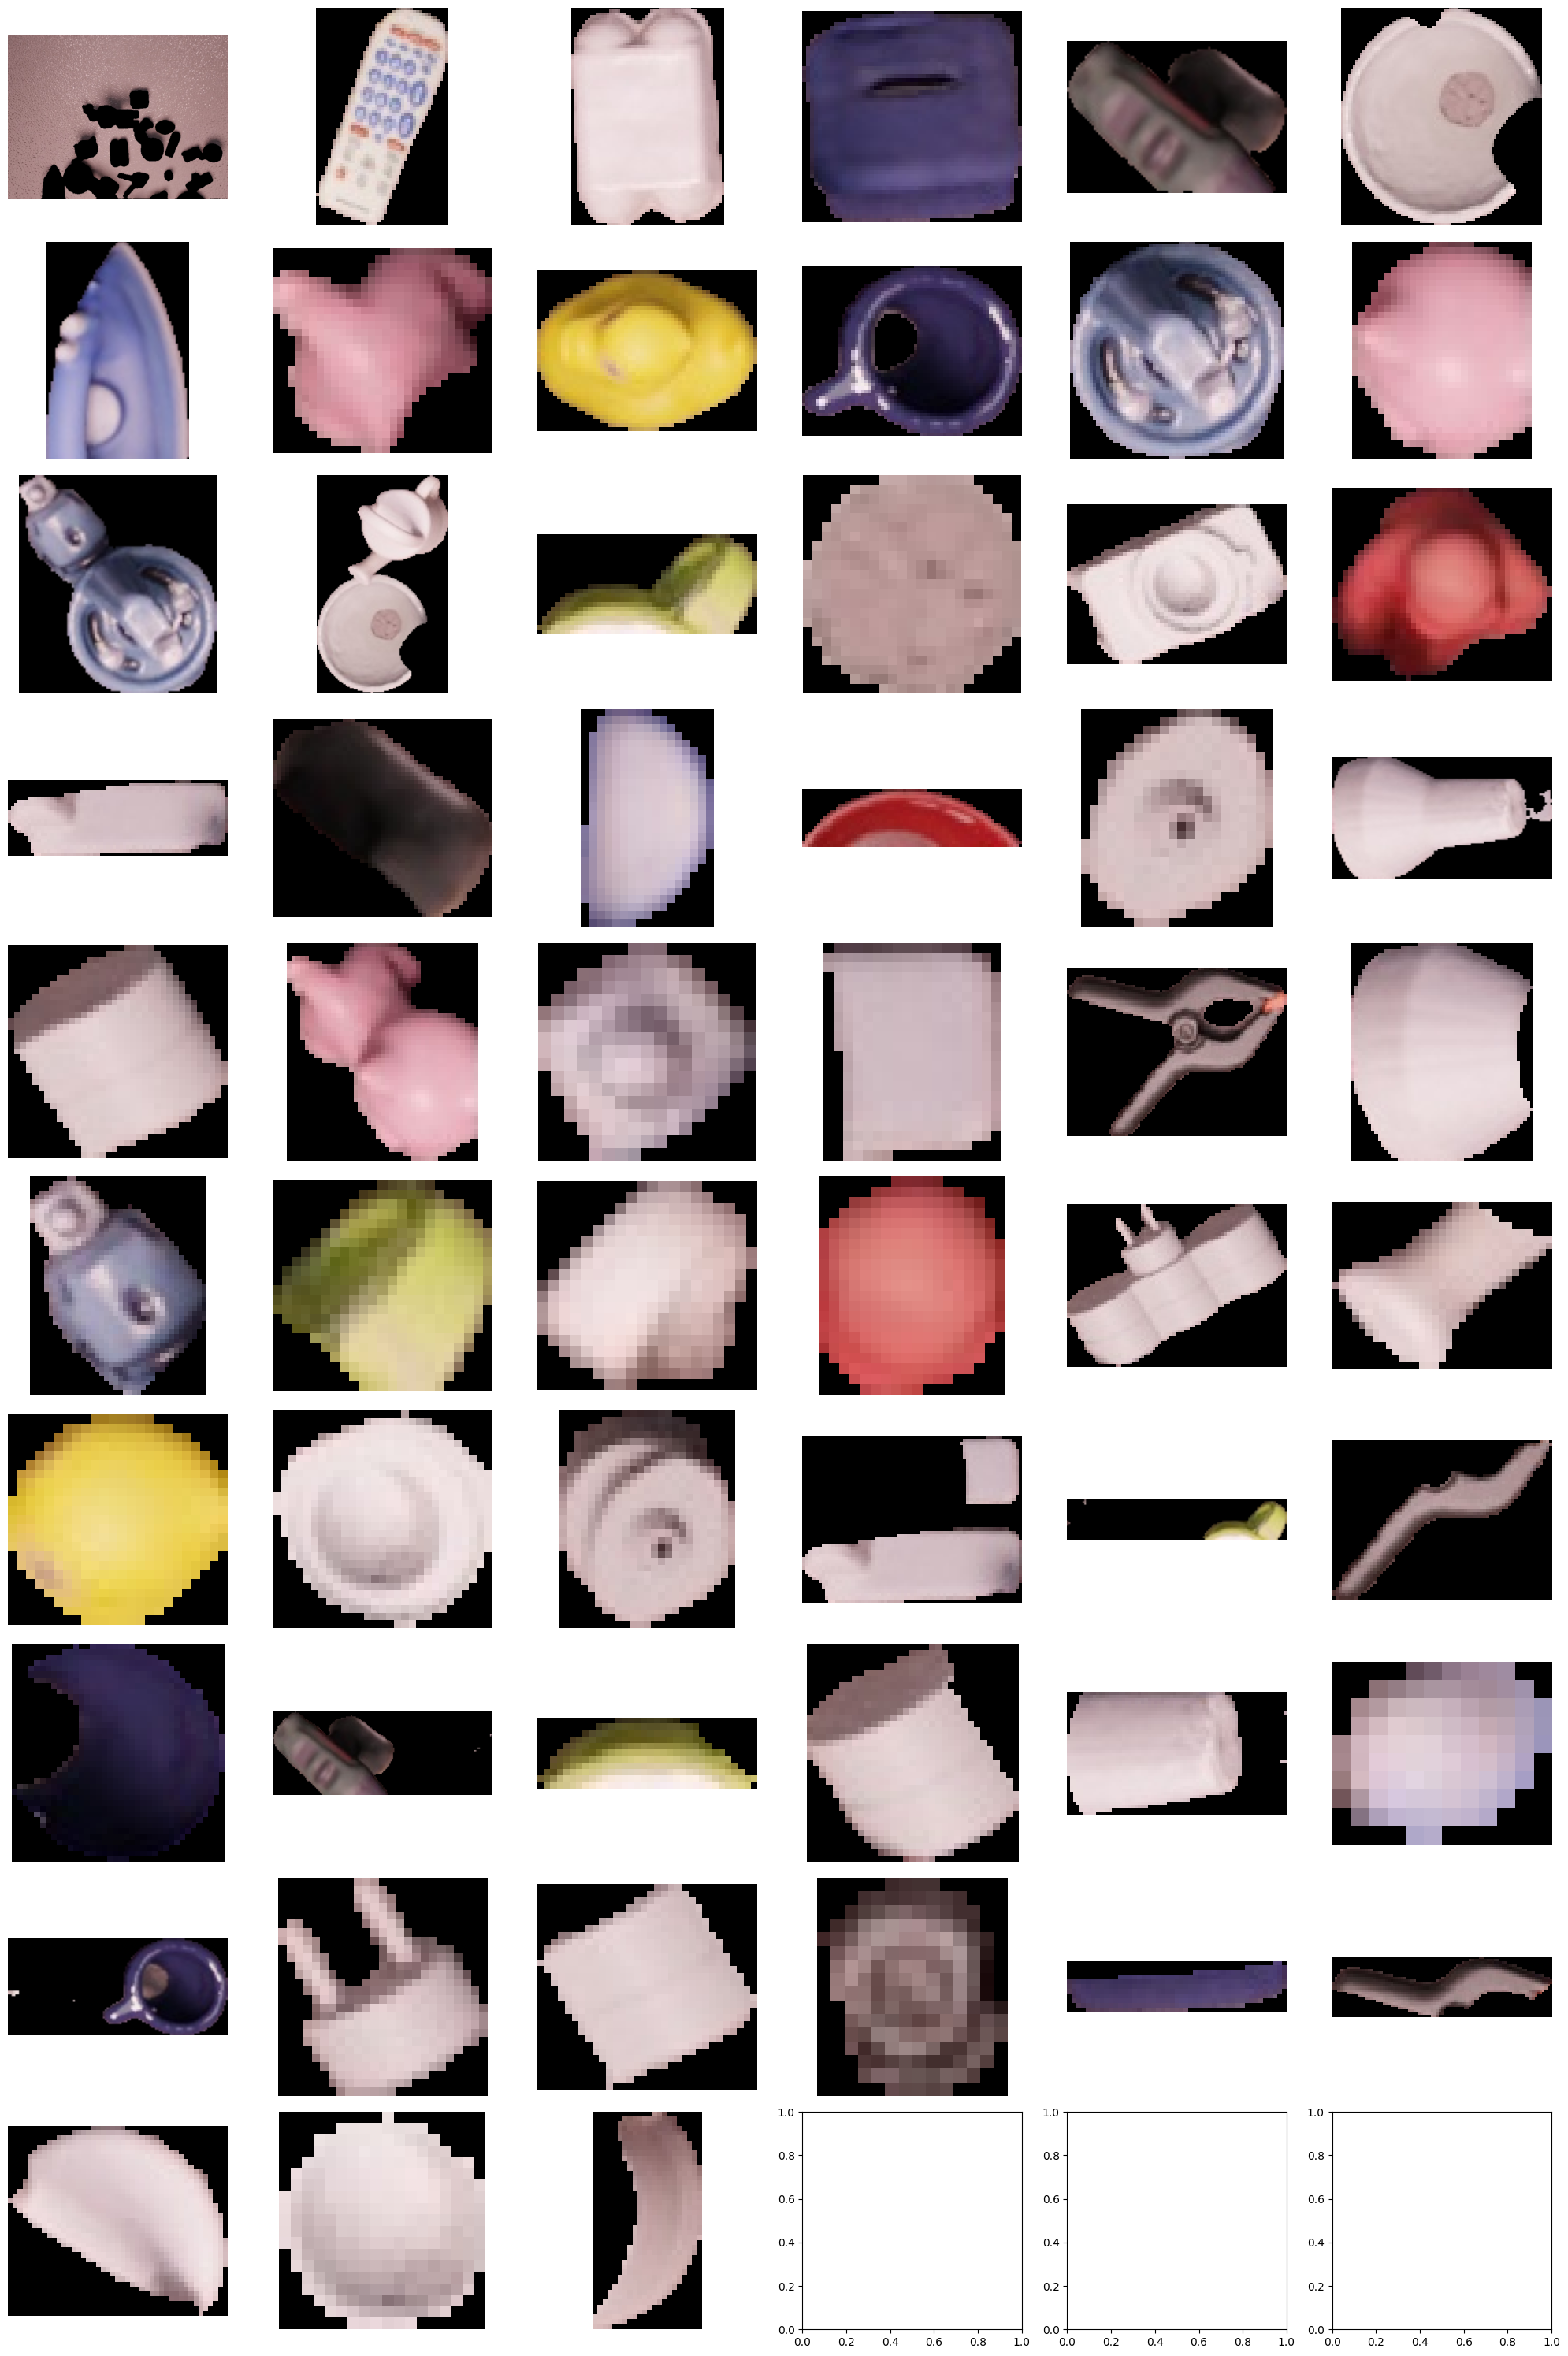

In [5]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

In [6]:
import os

# Choose crop 7 it is in object id 13
crop_idx = 6
obj_id = 13
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][crop_idx],
    "boxes" : detections["boxes"][crop_idx]
}
# save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")

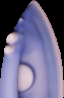

In [7]:
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [11]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
# initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

In [12]:
import os
import glob

default_ref_dataloader_config = cfg.data.reference_dataloader
ref_dataloader_config = default_ref_dataloader_config.copy()
ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
ref_dataloader_config.template_dir = " "

level_template = 0 # Level 0 :42 templates, level 1, 162 templates
ref_dataloader_config.level_templates = level_template 
ref_dataloader_config.split = "train_pbr"

ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/*.ply")
obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
ref_dataloader_config.obj_ids = obj_ids

out_folder = f"foundpose_analysis/{dataset}/templates"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
ref_dataloader_config.out_dir = out_folder
ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [56]:
# from hydra.utils import instantiate
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

Loading metaData: 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]
Finding nearest rendering close to template poses: 100%|██████████| 15/15 [00:00<00:00, 128.43it/s]


In [57]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/train_pbr_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(1,len(obj_ids)+1): 
#     obj_id_path = os.path.join(f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr", f'obj_{(ob_id):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr", f'obj_{(ob_id):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)
        
#     for i, img in enumerate(ref_dataset[ob_id-1]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#         save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#     for i, img in enumerate(ref_dataset[ob_id-1]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#         save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))

## 2.2. Patch descriptors register in 3D for templates

In [59]:
import glob
import os

obj_id = 13
# Load original templates when before putting through dinov2 we also apply transfomation.
template_path = f"{out_folder}/synthetic_images_templates/{dataset}/train_pbr/obj_{obj_id:06d}_original" 
template_files = sorted(glob.glob(os.path.join(template_path, "*.png")), key=os.path.getmtime)
num_templates = len(template_files)
num_templates

42

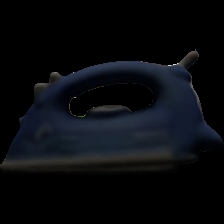

In [60]:
Image.open(template_files[2])

In [61]:
from PIL import Image
import numpy as np

templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3]/255.0 for template_file in template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [63]:
from src.model.foundpose import (
    crop_feature_extraction, 
    kmeans, 
    calculate_templates_labels, 
    calculate_templates_vector,
    calculate_crop_vector,
    calculate_similarity,
    templates_feature_extraction
)


pca_patches_descriptors, num_valid_patches = templates_feature_extraction(
    templates = templates, num_templates = num_templates, dino_model = dinov2_vitl14, device = device
    )

normalized_templates shape torch.Size([3, 224, 224])
scaled_padded_templates.shape 42 torch.Size([3, 420, 420])
pca_crop_patches_descriptors.shape (8858, 256)


## 2.4 Perform Kmean clustering for all patch descriptors from templates (2048 clusters)

In [64]:
kmeans = kmeans(pca_patches_descriptors, ncentroids = 2048, niter = 20, verbose = True)

Clustering 8858 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.06 s, search 0.03 s): objective=5.2911e+06 imbalance=1.274 nsplit=0       


WARNING clustering 8858 points to 2048 centroids: please provide at least 79872 training points


In [65]:
templates_labels = calculate_templates_labels(num_valid_patches, kmeans, pca_patches_descriptors)
templates_vector = calculate_templates_vector(templates_labels = templates_labels, num_clusters = 2048)

# 3. BoW descriptor for rgb crop

In [66]:
# Load image crop 
crop_rgb = np.array(Image.open(f"foundpose_analysis/{dataset}/crop1.png").convert("RGB"))/255.0 # (124, 157, 3)

In [67]:
pca_crop_patches_descriptors, num_valid_patches = crop_feature_extraction(crop_rgb = crop_rgb, dino_model = dinov2_vitl14, device = device)

(413, 256)


In [68]:
# Assign labels to the data points
crop_labels = kmeans.index.search(pca_crop_patches_descriptors, 1)[1].reshape(-1)
crop_labels.shape

(413,)

In [69]:
crop_vector = calculate_crop_vector(crop_labels = crop_labels, templates_labels = templates_labels, num_clusters = 2048)
concat_templates_vector = torch.cat([torch.tensor(vector).view(1,-1) for vector in templates_vector]) # Goal torch.Size([642, 2048])

In [70]:
print(concat_templates_vector.shape)
print(crop_vector.shape)

torch.Size([42, 2048])
torch.Size([1, 2048])


# 4. Retrieve top similar pose

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from src.model.loss import PairwiseSimilarity, Similarity
from torchvision.io import read_image
metric = Similarity() # cnos  uses PairwiseSimilariy - what is the difference between Similarity and Pairwise Similarity ?

def calculate_similarity(crop_rgb, feature_decriptors, ref_features, metric, synthetic=False):
    # get scores per proposal
    scores = metric(feature_decriptors[:, None, :], ref_features[None, :, :]) # should get  # N_proposals x N_objects x N_templates -get only 1,42 as num_prosals*num_templates instead
    score_per_detection, similar_template_indices = torch.topk(scores, k=5, dim=-1) # get top 5 most similar templates
    # get the final confidence score
    score_per_detection = torch.mean(
        score_per_detection, dim=-1
    ) 
    # Check the confidence scores for the similar templates
    similar_scores = scores[:, similar_template_indices[0].to("cpu")]

    similar_templates = []
    for i in range(len(similar_template_indices[0])):
        if synthetic:
            img = read_image(f"foundpose_analysis/{dataset}/templates/synthetic_images_templates/{dataset}/train_pbr/obj_{obj_id:06d}_original/{(similar_template_indices[0][i]):06d}.png")            
        # else:
        #     img = read_image(f"cnos_analysis/real_images_templates/icbin/obj_000001_original/{(similar_template_indices[0][i]):06d}.png")        
        similar_templates.append(img)
    template_images = torch.stack(similar_templates)

    # Display the crop
    plt.imshow(crop_rgb)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    print("top 5 confidence scores", similar_scores)
    print("final average confidence score", score_per_detection)

    width = 50
    height = 50
    fig = plt.figure(figsize=(15, 15))
    columns = 3
    rows = 2

    for index in range(len(template_images)):
        fig.add_subplot(rows, columns, index + 1)
        img = template_images[index].permute(1, 2, 0)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Top Template {index + 1}')

    plt.tight_layout()
    plt.show()

    return

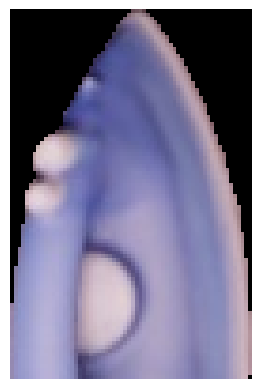

top 5 confidence scores tensor([[0.1597, 0.0899, 0.0806, 0.0790, 0.0788]], dtype=torch.float64)
final average confidence score tensor([0.0976], dtype=torch.float64)


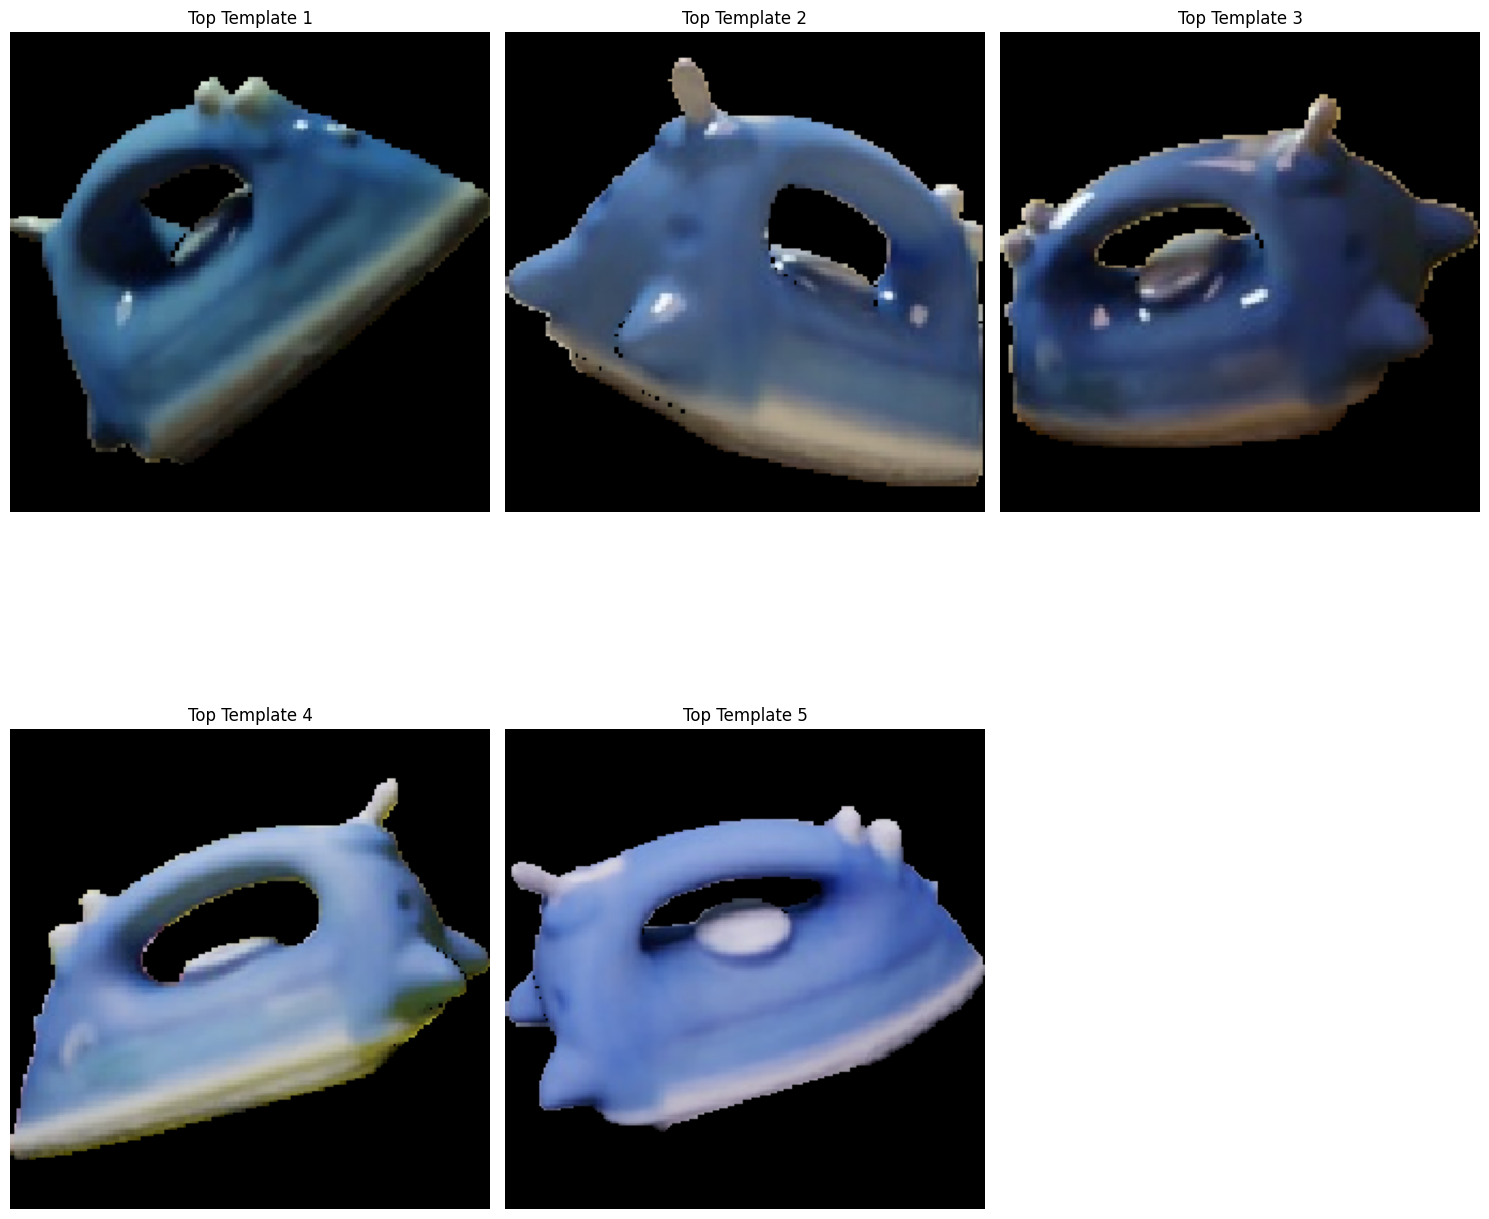

In [72]:
calculate_similarity(crop_rgb, crop_vector, concat_templates_vector, metric, synthetic=True)